In [1]:
using FFTW

In [2]:
using Statistics

In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: Error requiring `StaticArrays` from `ArrayInterface`
│   exception = (ErrorException("too many parameters for type"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000068f84117, Ptr{Nothing} @0x0000000068ff06a9, Ptr{Nothing} @0x000000006901236c, Ptr{Nothing} @0x0000000069012031, Ptr{Nothing} @0x0000000069012b40, Ptr{Nothing} @0x0000000069013515, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 82, Ptr{Nothing} @0x0000000069030c9d, Ptr{Nothing} @0x000000006903241a, Ptr{Nothing} @0x0000000024a064bf, Ptr{Nothing} @0x0000000024a064e3, Ptr{Nothing} @0x000000001a1ec5b1, Ptr{Nothing} @0x0000000024a0640a, Ptr{Nothing} @0x0000000024a06433, Ptr{Nothing} @0x000000001a1ebf18, Ptr{Nothing} @0x0000000024a06371, Ptr{Nothing} @0x0000000024a063a3, Ptr{Nothing} @0x000000001a1e7b0e, Ptr{Nothing} @0x000000001a1eea74, Ptr{Nothing} @0x000000001a1eed93, Ptr{Nothing} @0x0000000069030130, Ptr{Nothing} @0x0000000069026590, Ptr{Nothing} @0x000000001a19d327, Ptr{No

In [4]:
using Plots
gr()  

Plots.GRBackend()

# Properies

### Earth property

In [5]:
g = 9.8

9.8

### Solid Physical parameters

In [6]:
ρₛ = 2730; # density
# cₛ  = 8.97e02; # specific heat
cₛ  = 8.93e02; # specific heat
# kₛ  = 1.67e02; # heat conductivity
kₛ  = 1.93e02; # heat conductivity
# d = 2e-3;
plate_d = 1.5e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

In [7]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [8]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [9]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [10]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0006333345639056725, 0.001520002953373614)

### Set up the evaporator and condenser

In [11]:
inch = 2.54e-2;

In [12]:
power = 40 #watts
total_heater_area = 2.0inch*2.0inch;

In [13]:
qe = power/total_heater_area
hc = 1500.0 *1.5
Tc = Tᵥ

291.2

In [14]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [15]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = 1e-3
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
# one_loop_gap = 1e-2
# x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


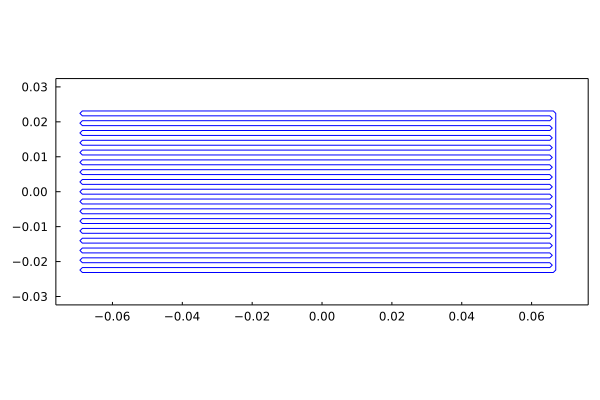

In [16]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [17]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [18]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [19]:
qtmp = zeros(numpts(ohp));

In [20]:
u0 = newstate(sys)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator) .+ Tᵥ;

In [21]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [22]:
num = 100
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

  2.806315 seconds (2.74 M allocations: 1.187 GiB, 7.31% gc time)


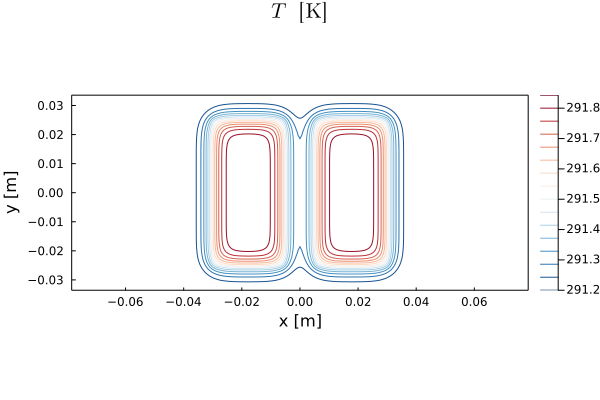

In [23]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

# OHP inner part

### Tube geometries

In [24]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [25]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [26]:
Nu = 4.36
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

469.15728016589026

In [27]:
X0,realratio = randomXp(L,numofslugs=30,chargeratio=0.45)
# X0 = [(L/2,L/2+L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [28]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [29]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [30]:
Hᵥ = kᵥ/tube_d * Nu # Nusselt number 4.36

69.29503570524817

In [31]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
δ = 0*zeros(length(X0)) .+ 1.0e-5;
# δratio = 0*zeros(length(X0)) .+ 0.99;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δmin = mean(δ) * 0.5
vapors=Vapor(Hᵥ,kₗ,δmin,P,δ);

### Wall

### nucleate boiling sites

In [32]:
ΔTthres = 1.0; # superheat threshold

In [33]:
    nucleatenum = 256
#     Xstations = sort(rand(nucleatenum).*L);
    Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

256-element LinRange{Float64}:
 0.0,0.0181667,0.0363334,0.0545,…,4.55984,4.578,4.59617,4.61434,4.6325

In [34]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [35]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [36]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [37]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [38]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# load old data

In [39]:
# integrator_plate = load("plate_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_plate")
# sys = integrator_plate.p

In [40]:
# integrator_tube = load("tube_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_tube")

# # sysfinal = []
# # for i = 1:length(tube_hist)
# #     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# # end

In [41]:
# tube_hist = load("tube_vibration.jld2", "tube_hist")

# combine inner tube and plate together

In [52]:
tspan = (0.0, 1.0);
dt_record = tspan[2] /100;
# dt_record = 0.1;

tstep=5e-4

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [53]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ;

In [54]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [55]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [56]:
@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
#         push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.010000000000000005
0.020000000000000014
0.030000000000000023
0.04000000000000003
0.05000000000000004
0.060000000000000046
0.07000000000000005
0.08000000000000006
0.09000000000000007
0.10000000000000007
0.11000000000000008
0.12000000000000009
0.1300000000000001
0.1400000000000001
0.1500000000000001
0.16000000000000011
0.17000000000000012
0.18000000000000013
0.19000000000000014
0.20000000000000015
0.21000000000000016
0.22000000000000017
0.23000000000000018
0.24000000000000019
0.25000000000000017
0.2600000000000002
0.2700000000000002
0.2800000000000002
0.2900000000000002
0.3000000000000002
0.3100000000000002
0.32000000000000023
0.33000000000000024
0.34000000000000025
0.35000000000000026
0.36000000000000026
0.3700000000000003
0.3800000000000003
0.3900000000000003
0.4000000000000003
0.4100000000000003
0.4200000000000003
0.4300000000000003
0.44000000000000034
0.45000000000000034
0.46000000000000035
0.47000000000000036
0.48000000000000037
0.4900000000000004
0.5000000000000003
0.509999999999

In [57]:
L

4.650670248837521

In [58]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
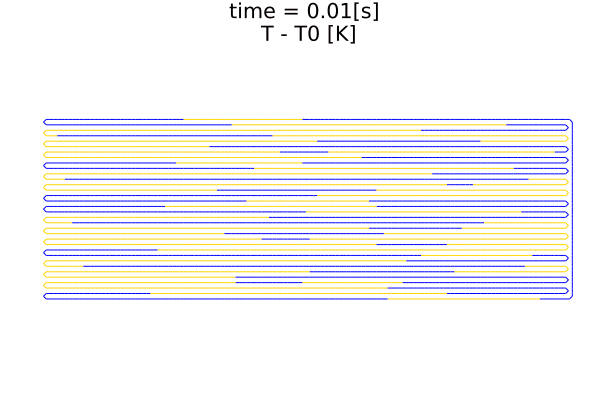

In [66]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=palette([:blue, :gold], 100),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

# plot the OHP

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
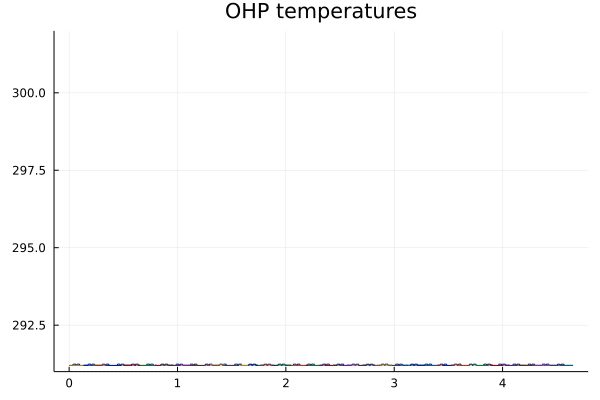

In [429]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",ylim=(291.0,302.0))
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
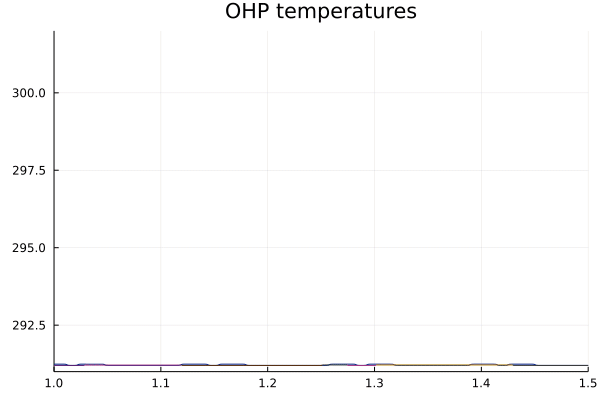

In [430]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",ylim=(291.0,302.0),xlim=(1.0,1.5))
end

In [432]:
sysfinal[end].vapor.δ

25-element Array{Float64,1}:
 1.1679980419382479e-5
 9.62924038742321e-6
 6.595255509658889e-6
 1.8977376943235866e-5
 1.268378718548436e-5
 1.1386435676365484e-5
 1.0271700427711225e-5
 1.1029188097376771e-5
 1.016449358380067e-5
 1.045273116964685e-5
 1.616947997497295e-5
 9.730229999078387e-6
 9.524273642866676e-6
 9.650906351564348e-6
 5.535754510233393e-6
 9.287849832934206e-6
 1.0034489024922937e-5
 9.998849299039138e-6
 1.648673783528083e-5
 8.69275382193584e-6
 9.653272362996596e-6
 9.676439252653978e-6
 9.004944388126034e-6
 8.695568529567004e-6
 9.619584721746913e-6

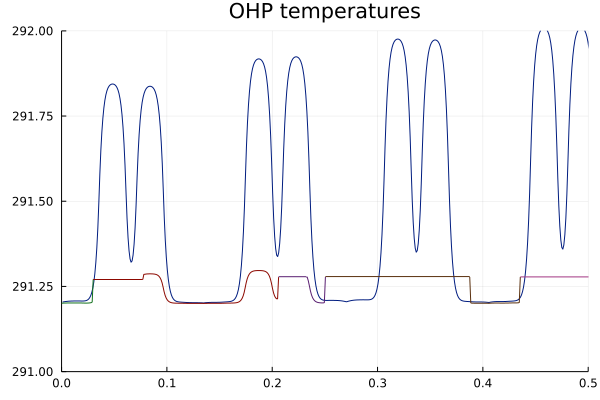

In [348]:
plot(sysfinal[end-30],plottype="T",ylim=(291.0,292.0),xlim=(0.0,0.5))

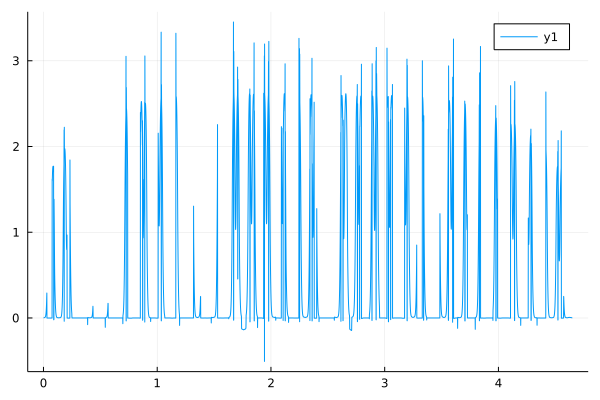

In [349]:
plot(sys.qline[1].arccoord,sys.qline[1].q)

In [350]:
plot(temperature(plate_hist[end-1]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=string("time =  [s] \n",  "T - T0 [K]"))

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [-1][39m

In [351]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = Tᵥ
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,clim=(Tmin,Tmax),color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"))
end

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [-1][39m

In [352]:
# save("plate_vibration2.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [353]:
# save("tube_vibration2.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [354]:
# plate_hist, integrator_plate = load("plate_OHP_dimensional50D0.3TH1_fixed_new.jld2", "plate_hist",  "integrator_plate")
# sys = integrator_plate.p

In [355]:
# tube_hist, integrator_tube = load("tube_OHP_dimensional50D0.3TH1_fixed_new.jld2", "tube_hist",  "integrator_tube")

# sysfinal = []
# for i = 1:length(tube_hist)
#     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# end

In [356]:
RTDx,RTD1,RTD4 = load("RTD.jld2","RTDx","RTD1","RTD4")

(0:53, [291.2, 291.2, 291.6, 291.8, 292.1, 292.5, 292.7, 293.1, 293.1, 293.6  …  295.8, 295.7, 295.7, 295.9, 295.9, 295.9, 296.1, 295.7, 295.9, 295.9], [291.2, 292.7, 294.0, 295.0, 295.6, 296.3, 296.8, 297.3, 297.7, 298.1  …  301.2, 301.3, 301.4, 301.4, 301.4, 301.5, 301.4, 301.7, 301.6, 301.6])

In [357]:
x = [-3.0inch,0.0]
y = [0.0,0.0]

X =  VectorData(x,y);

In [358]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [359]:
ghist = []

size(g)
for j = 1:length(g)
    gtemp = []
    for i = 1:length(plate_hist)
        H(g,temperature(plate_hist[i]))
        append!(gtemp,deepcopy(g[j]))
    end
    push!(ghist,deepcopy(gtemp))
end

In [360]:


thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

In [361]:
# ghist = [Tᵥ;Tᵥ]
# for i = 1:length(plate_hist)
#     H(g,temperature(plate_hist[i]))
# #     println(g)
# #     push!(ghist,deepcopy(g))
#     ghist = hcat(ghist,g)
#     append!(thist,plate_hist[i].t)
# end


In [362]:
ghist

2-element Array{Any,1}:
 Any[]
 Any[]

In [363]:
thist[1,:]

1-element Array{Any,1}:
 0.009500000000000005

In [364]:
plot(thist,ghist[1])
plot!(thist,ghist[2])
scatter!(RTDx,RTD4)
scatter!(RTDx[1:end-1],RTD1)

BoundsError: [91mBoundsError: attempt to access 0-element Array{Float64,1} at index [1:51][39m

In [365]:
sysfinal[end].liquid.Xp[4][2]-sysfinal[end].liquid.Xp[4][1]

0.03295305146530758

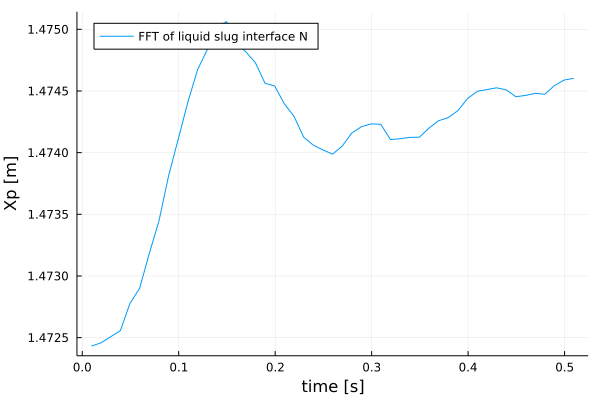

In [366]:
Xp_hist = zeros(length(sysfinal))
num = 2
for i = 1:length(sysfinal)
    for j = length(sysfinal[i].liquid.Xp)
#         Xp_hist[i] = sysfinal[i].liquid.Xp[end][end]
        Xp_hist[i] = sysfinal[i].liquid.Xp[1][1]
    end
end

# plot(thist,Xp_hist,label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")
plot(thist,Xp_hist,label= "FFT of liquid slug interface N",xlabel="time [s]",ylabel="Xp [m]",legend=:topleft)

In [367]:
dtt = 0.01
fs = 1/dtt

100.0

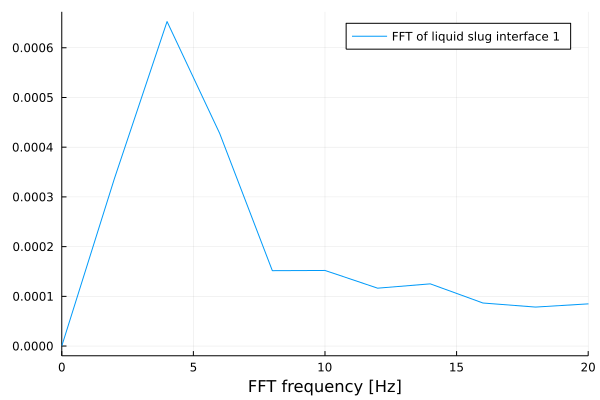

In [368]:
LL = length(Xp_hist)
Y= fft(Xp_hist .- sum(Xp_hist)./LL )

P2 = abs.(Y/LL);
P1 = P2[1:Int64((LL-1)/2+1)];
P1[2:end-1] = 2*P1[2:end-1];
plot(LinRange(0.0,0.5fs,length(P1)),P1,xlim=(0,20),label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")

In [369]:
plot(Xp1_hist)

LoadError: [91mUndefVarError: Xp1_hist not defined[39m

In [370]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



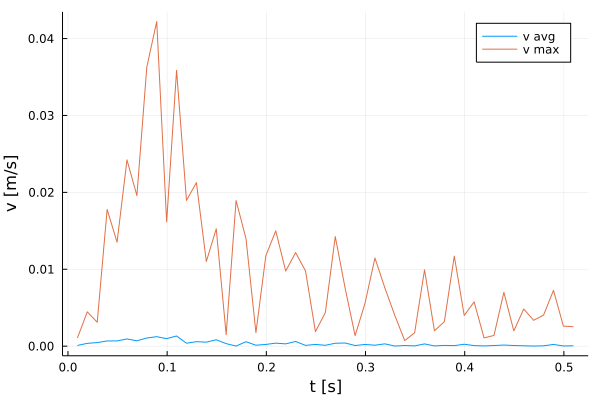

In [371]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [372]:
# oneXpvapor=(3.0,1.5)
# L = 4.0

In [373]:
oneLvapor = mod.(oneXpvapor[2]-oneXpvapor[1],L)

3.150670248837521

In [374]:
using Interpolations

In [375]:
xs[end] > xs[1]

LoadError: [91mUndefVarError: xs not defined[39m

In [376]:
d = tube_d
δmin = 5e-3*d

5.0e-6

In [377]:
δmin:1e-6:d/2

5.0e-6:1.0e-6:0.0005

In [378]:
plot(δmin*0.1:1e-6:d/2,Hfilm_interpolation2(δmin*0.1:1e-6:d/2))

LoadError: [91mUndefVarError: Hfilm_interpolation2 not defined[39m

In [379]:
1/Hfilm_interpolation_inverse(δmin)

LoadError: [91mUndefVarError: Hfilm_interpolation_inverse not defined[39m

In [380]:
δfilm

LoadError: [91mUndefVarError: δfilm not defined[39m

In [381]:
Hᵥ

69.29503570524817

In [382]:
Hfilm(δfilm) = δfilm > δmin ? kₗ/δfilm : Hᵥ + δfilm*(kₗ/δmin - Hᵥ)/δmin 

Hfilm (generic function with 2 methods)

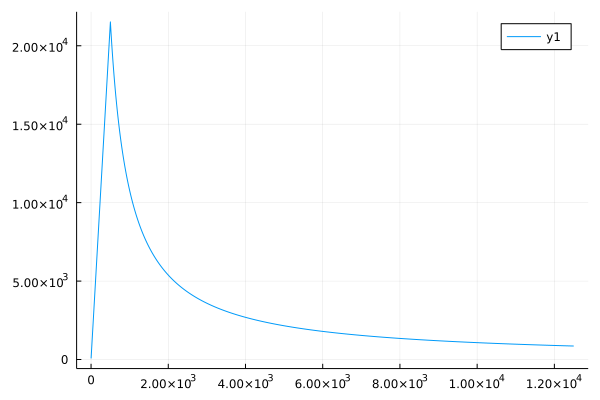

In [383]:
plot(Hfilm.(0.0:1e-8:d/8))

In [384]:
Hfilm_interpolation[d/8]

LoadError: [91mUndefVarError: Hfilm_interpolation not defined[39m

In [385]:
# function getvaporHarray(xs,oneδratio,Hf,Hv,L)
#     oneLvapor = mod.(xs[end]-xs[1],L)
#     half_film_L = 0.5*oneδratio*oneLvapor
#     x_interpolate = Float64[]
#     H_interpolate = Float64[]
    

#     if xs[end] > xs[1]
#         x_interpolate = [xs[1],xs[1]+half_film_L,xs[1]+half_film_L,xs[end]-half_film_L,xs[end]-half_film_L,xs[end]]
#         H_interpolate = [Hf,Hf,Hv,Hv,Hf,Hf]
#     elseif (xs[1]+half_film_L < L) && (xs[end]-half_film_L > 0.0)
#         x_interpolate = [0.0,xs[end]-half_film_L,xs[end]-half_film_L,xs[end],xs[1],xs[1]+half_film_L,xs[1]+half_film_L,L]
#         H_interpolate = [Hv,Hv,Hf,Hf,Hf,Hf,Hv,Hv]
#     elseif (xs[1]+half_film_L > L) && (xs[end]-half_film_L > 0.0)
#         x_interpolate = [0.0,mod(xs[1]+half_film_L,L),mod(xs[1]+half_film_L,L),xs[end]-half_film_L,xs[end]-half_film_L,xs[end],xs[1],L]
#         H_interpolate = [Hf,Hf,Hv,Hv,Hf,Hf,Hf,Hf]
#     else
#         x_interpolate = [0.0,xs[end],xs[1],xs[1]+half_film_L,xs[1]+half_film_L,mod(xs[end]-half_film_L,L),mod(xs[end]-half_film_L,L),L]
#         H_interpolate = [Hf,Hf,Hf,Hf,Hv,Hv,Hf,Hf]
#     end
    
# #             println(x_interpolate)
    
#     H_interpolation = LinearInterpolation(x_interpolate, H_interpolate);
    
#     H_interpolation
# end

In [386]:
Hvapors = getvaporHarray(xs,oneδratio,Hf,Hv,L)

LoadError: [91mUndefVarError: getvaporHarray not defined[39m

In [387]:
Hvapors(0.1:0.1:4.0)

LoadError: [91mUndefVarError: Hvapors not defined[39m

In [388]:
plot(x,H)

LoadError: [91mCannot convert Regularize{2,false} to series data for plotting[39m

In [389]:
Ac

1.0e-6

In [390]:
peri .* ((tube_d .- δ) / tube_d) .* δ

30-element Array{Float64,1}:
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 ⋮
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8
 3.9600000000000004e-8

In [391]:
Ac .- Ac .* ((tube_d .- 2 .* δ) / tube_d) .^ 2

30-element Array{Float64,1}:
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 ⋮
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8
 3.960000000000001e-8

In [392]:
Lvapor = XptoLvaporplug(p.liquid.Xp,p.tube.L,p.tube.closedornot)

30-element Array{Float64,1}:
 0.09262501556678271
 0.09913233588148485
 0.04508446088933726
 0.056290354527520625
 0.05094253052767339
 0.09346342115171113
 0.02483727584863704
 0.1337957779427259
 0.02215324969881749
 0.0721221409856847
 0.06839412341379525
 0.10972229993766369
 0.05070816499399777
 ⋮
 0.06736983547653885
 0.07886330372830574
 0.02136263427821472
 0.04700013788983881
 0.026106887772129106
 0.13673714482330546
 0.10700628453213312
 0.12949559620726525
 0.11370963582462856
 0.06685621934916774
 0.09786140970454138
 0.12214169485077697

In [393]:
dδdt = dMdt .* tube_d ./ ( (-4) .* (tube_d .- 2δ) .* ρₗ .* Lvapor .* Ac)

30-element Array{Float64,1}:
 -0.0
 -2.81895324355542e-17
 -6.887281443257502e-17
 -0.0
 -5.4985144131155594e-17
 -6.086433672471347e-17
 -0.0
  1.0496362002543042e-16
 -0.0
  7.754991100921837e-17
  4.107470963508984e-17
  5.110893704740147e-17
  2.2084148414324382e-16
  ⋮
  1.2436775185725243e-16
 -7.120560322539372e-17
 -0.0
 -2.9999010760345753e-16
 -1.0705114260220176e-16
 -0.0
 -2.6263477544339585e-17
  2.16388637042562e-17
 -0.0
 -8.412442849394638e-17
  1.139979129618428e-16
 -6.8950029179928e-17

In [394]:
dδdt = dMdt ./ ρₗ .* (peri .* ((tube_d .- δ) / tube_d) .* Lvapor)

30-element Array{Float64,1}:
  0.0
  4.300310404066488e-27
  2.173115678134939e-27
  0.0
  2.215070990887953e-27
  8.253297394405728e-27
  0.0
 -2.916788046275372e-26
  0.0
 -6.2618084417943736e-27
 -2.9825884406157026e-27
 -9.551419209541795e-27
 -8.814906286894852e-27
  ⋮
 -8.762338173569206e-27
  6.874567109853154e-27
  0.0
  1.0286945782274855e-26
  1.1326161878924073e-27
  0.0
  4.6682279327209644e-27
 -5.63281779582105e-27
  0.0
  5.836963907124191e-27
 -1.6947322286211417e-26
  1.596774510433843e-26

In [395]:
dMdt = dMdtdynamicsmodel(p.liquid.Xp,p)

30-element Array{Float64,1}:
 -1.2798642648645923e-20
  1.9045769856544263e-20
  6.365732869524575e-21
 -1.9199581019890145e-20
 -6.387615678158477e-21
 -6.356967855690839e-21
  6.4074432608374495e-21
 -4.4758000564857004e-20
  1.9204638741282558e-20
  1.2784231459519651e-20
  0.0
  3.1777124665784806e-20
  0.0
  ⋮
 -1.9206285016928824e-20
  0.0
 -1.2696743383995024e-20
 -1.916678164261002e-20
 -6.391073247655551e-21
 -3.1887043292976334e-20
  6.5200339347166675e-21
 -1.2760654123561755e-20
  1.2728336999524317e-20
 -1.9301732863911142e-20
  6.422279341656069e-21
 -6.375002792561995e-21

In [451]:
D = PtoD.(sysfinal[i].vapor.P)

30-element Array{Float64,1}:
 5.006389331859842
 5.007378516160238
 5.006300220156962
 5.005590596512669
 5.005170615409996
 5.004663835225834
 5.00472554188499
 5.004189180679834
 5.005035786692041
 5.005283155622254
 5.005932666606891
 5.005861783126292
 5.005438672648315
 ⋮
 5.006545971657537
 5.005983425341119
 5.0057618474914936
 5.005272675667284
 5.005698451358679
 5.005890649884379
 5.006033600025241
 5.00592315265568
 5.005768354072013
 5.005347915983741
 5.0054421606688715
 5.005998200122192

In [ ]:
dXdt_adjust = δarea / (Ac - δarea) * dXdt

dXdt_final = Ac / (Ac - δarea) * dXdt

In [67]:
i = 100
δarea = Ac .* (1 .- ((tube_d .- 2*sysfinal[i].vapor.δ ) ./ tube_d) .^ 2);
Lvaporplug = XptoLvaporplug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
δarea .* Lvaporplug .* ρₗ .+ PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
M1 = δarea .* Lvaporplug .* ρₗ
M2 = PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
println(M1+M2)
# println(M1)
# println(M2)

[2.531043268944435e-6, 2.482053233373374e-6, 2.9093905163134907e-6, 1.85041195037875e-7, 3.2929527328582524e-6, 2.502914124578346e-6, 2.302347864125819e-6, 3.314961623816822e-6, 3.58694872915331e-6, 2.9300633027320535e-6, 2.161208635987441e-6, 1.458235400148515e-6, 2.3705363485172107e-6, 2.6025634112317506e-6, 2.5142781327871643e-7, 4.164635872100567e-6, 1.5196204324267507e-6, 6.60382297850029e-6, 4.701845140784093e-6, 4.158174392655049e-6, 6.710745683663611e-8, 2.751672612076101e-6, 2.5898201028719633e-6, 3.398227530443752e-7, 4.0296533242141183e-7, 1.5157277476064355e-6, 2.0381519869737126e-6]
